# Week 10 - Aditya Sumbaraju
http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# loading libraries
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot
import statsmodels.formula.api as smf

## Exercise 12.1

In [2]:

## Solution

## importing transactions
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
transactions.head()

## Defining GroupByDay function
def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

### Creating dailies
def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions
    
    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

## Extracting dailies
dailies = GroupByQualityAndDay(transactions)


### Creating the quadratic function

def RunQuadraticModel(daily):
    """Runs a linear model of prices versus years.

    daily: DataFrame of daily prices

    returns: model, results
    """
    daily['years2'] = daily.years**2
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results

In [3]:
## Fitting the mmodel
name = 'high'
daily = dailies[name]

model, results = RunQuadraticModel(daily)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Sun, 23 May 2021   Prob (F-statistic):          4.57e-164
Time:                        18:12:57   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

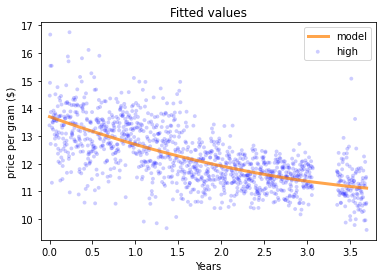

In [4]:
## Defining the PlotFittedValues function
def PlotFittedValues(model, results, label=''):
    """Plots original data and fitted values.

    model: StatsModel model object
    results: StatsModel results object
    """
    years = model.exog[:,1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model', color='#ff7f00')


## Plotting the fitted values

PlotFittedValues(model, results, label=name)
thinkplot.Config(title='Fitted values',
                 xlabel='Years',
                 xlim=[-0.1, 3.8],
                 ylabel='price per gram ($)')

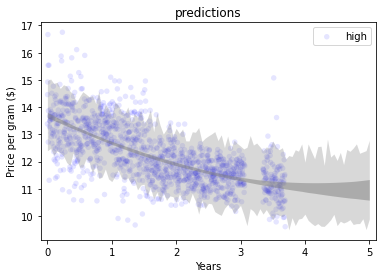

In [5]:


## Defining the RunLinearModel() function
def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

## Defining SimulateResults() functions
def SimulateResults(daily, iters=101, func=RunLinearModel):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq


## Defining GeneratePredictions function
def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    
    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq
    

## Defining the PlotPredictions() functions
def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

## Predicted observations
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(title='predictions',
                 xlabel='Years',
                 xlim=[years[0]-0.1, years[-1]+0.1],
                 ylabel='Price per gram ($)')

## Exercise 12.2

In [12]:
# function computes serial correlation with the given lag
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [13]:

# defining SerialCorrelationTest

# Definition for Class SerialCorrelationTest that extends HypothesisTest
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    # Using Permutation Test

    def TestStatistic(self, data):
        # series and lag as data
        series, lag = data
        # compute serial correlation as test statistic
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [14]:
# Testing Raw Data for Serial Correlation
for name, daily in dailies.items():
    series = daily.ppg
    # testing with lag 1
    test = SerialCorrelationTest((series, 1))
    pvalue = test.PValue()
    display(name)
    display(test.actual, pvalue)

'high'

0.485229376194738

0.0

'low'

0.11657497441101058

0.0

'medium'

0.16006429989181087

0.0

the above results indicates the raw data is significant for all three qualities - high, medium and low

In [15]:
## serialCorrelation function
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr


# test the correlation between consecutive prices

name = 'high'
daily = dailies[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.485229376194738 0.0


In [16]:
# test for serial correlation in residuals of the linear model

for name, daily in dailies.items():
    _, results = RunLinearModel(daily)
    series = results.resid
    test = SerialCorrelationTest((series, 1))
    pvalue = test.PValue()
    display(name)
    display(test.actual, pvalue)

'high'

0.07570473767506261

0.006

'low'

0.08950837134781882

0.002

'medium'

0.11560586074035996

0.0


linear model data is significant for all three qualities - high(0.6%), medium(0.2%) and low(0)

In [17]:
# test for serial correlation in residuals of the quadratic model
# test for serial correlation in residuals of the quadratic model
for name, daily in dailies.items():
    _, results = RunQuadraticModel(daily)
    series = results.resid
    test = SerialCorrelationTest((series, 1))
    pvalue = test.PValue()
    display(name)
    display(test.actual, pvalue)

'high'

0.05607308161289916

0.051

'low'

0.0822265937058341

0.003

'medium'

0.08089524938917432

0.007

The quadratic model data is significant for qualities - medium(0.7%) and low(0.3%) And somewhat nearly significant for high(5.1%)